In [26]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: []


## 3. Dataset Construction and Analysis

### 3.1 Dataset Overview

Our dataset combines:
- **Base dataset**: FER2013 with synthetic mask overlays
- **Metadata**: Age, gender, and ethnicity predictions using DeepFace
- **Emotion categories**: 7 categories (angry, disgust, fear, happy, neutral, sad, surprise)
- **Image format**: 48x48 grayscale images


In [27]:
# Load and examine the dataset
df = pd.read_csv("facial_emotion_dataset_with_metadata.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (20484, 6)

Columns: ['split', 'emotion', 'age', 'gender', 'ethnicity', 'pixels']

First few rows:


,split,emotion,age,gender,ethnicity,pixels
0,train,angry,28,"{'Woman': np.float32(3.0556154), 'Man': np.flo...",white,76 78 78 71 61 56 57 61 60 60 54 56 84 119 127...
1,train,angry,27,"{'Woman': np.float32(11.389782), 'Man': np.flo...",white,151 151 150 153 145 122 119 141 170 179 176 16...
2,train,angry,26,"{'Woman': np.float32(0.08126159), 'Man': np.fl...",white,29 28 18 15 24 32 44 63 87 100 115 126 134 139...
3,train,angry,34,"{'Woman': np.float32(2.3079233), 'Man': np.flo...",white,32 20 18 53 47 40 29 48 95 105 20 16 39 10 31 ...
4,train,angry,34,"{'Woman': np.float32(99.676956), 'Man': np.flo...",white,226 219 200 189 204 214 181 133 105 93 39 39 5...


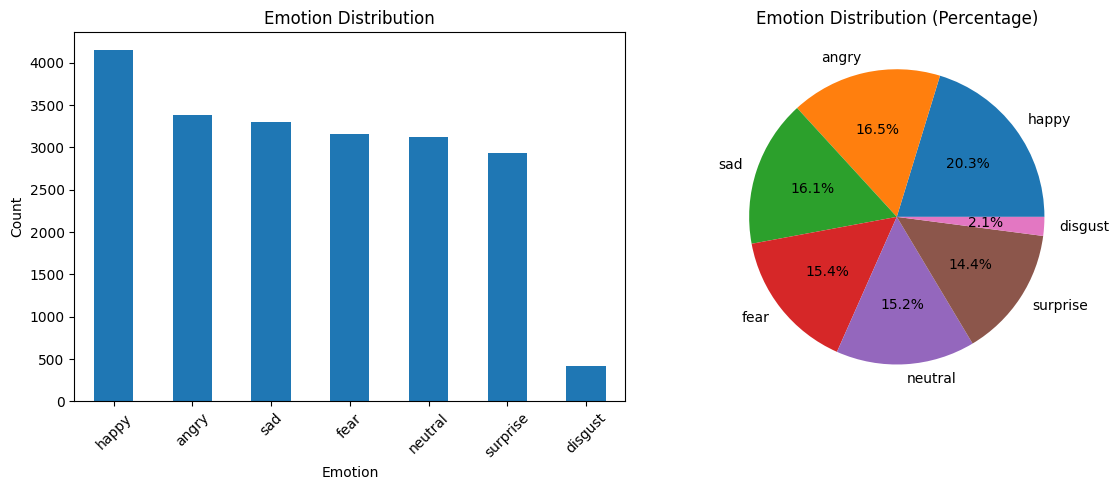

Emotion distribution:
emotion
happy       4152
angry       3387
sad         3301
fear        3163
neutral     3118
surprise    2940
disgust      423
Name: count, dtype: int64

Class imbalance ratio: 9.82


In [28]:
# Analyze emotion distribution
emotion_counts = df['emotion'].value_counts()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
emotion_counts.plot(kind='bar')
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%')
plt.title('Emotion Distribution (Percentage)')

plt.tight_layout()
plt.show()

print("Emotion distribution:")
print(emotion_counts)
print(f"\nClass imbalance ratio: {emotion_counts.max() / emotion_counts.min():.2f}")

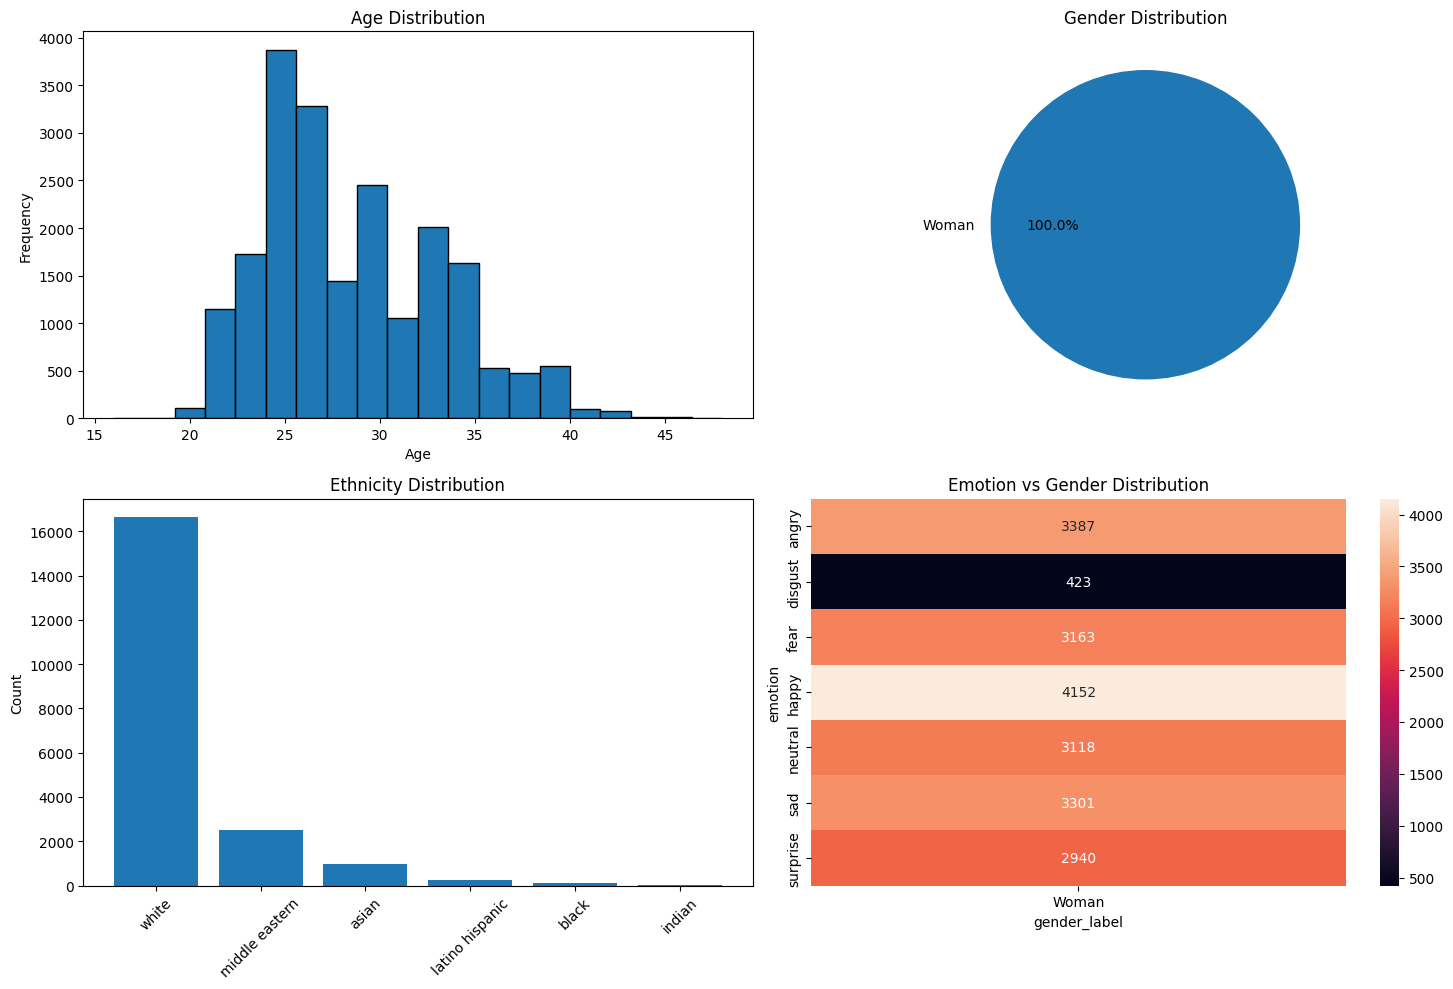

In [29]:
# Analyze demographic distribution
def extract_gender(gender_dict):
    try:
        return list(eval(gender_dict).keys())[0]
    except:
        return 'Unknown'

df['gender_label'] = df['gender'].apply(extract_gender)

# Create visualizations for demographics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age distribution
axes[0, 0].hist(df['age'], bins=20, edgecolor='black')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')

# Gender distribution
gender_counts = df['gender_label'].value_counts()
axes[0, 1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('Gender Distribution')

# Ethnicity distribution
ethnicity_counts = df['ethnicity'].value_counts()
axes[1, 0].bar(range(len(ethnicity_counts)), ethnicity_counts.values)
axes[1, 0].set_title('Ethnicity Distribution')
axes[1, 0].set_xticks(range(len(ethnicity_counts)))
axes[1, 0].set_xticklabels(ethnicity_counts.index, rotation=45)
axes[1, 0].set_ylabel('Count')

# Emotion vs Gender crosstab
emotion_gender = pd.crosstab(df['emotion'], df['gender_label'])
sns.heatmap(emotion_gender, annot=True, fmt='d', ax=axes[1, 1])
axes[1, 1].set_title('Emotion vs Gender Distribution')

plt.tight_layout()
plt.show()

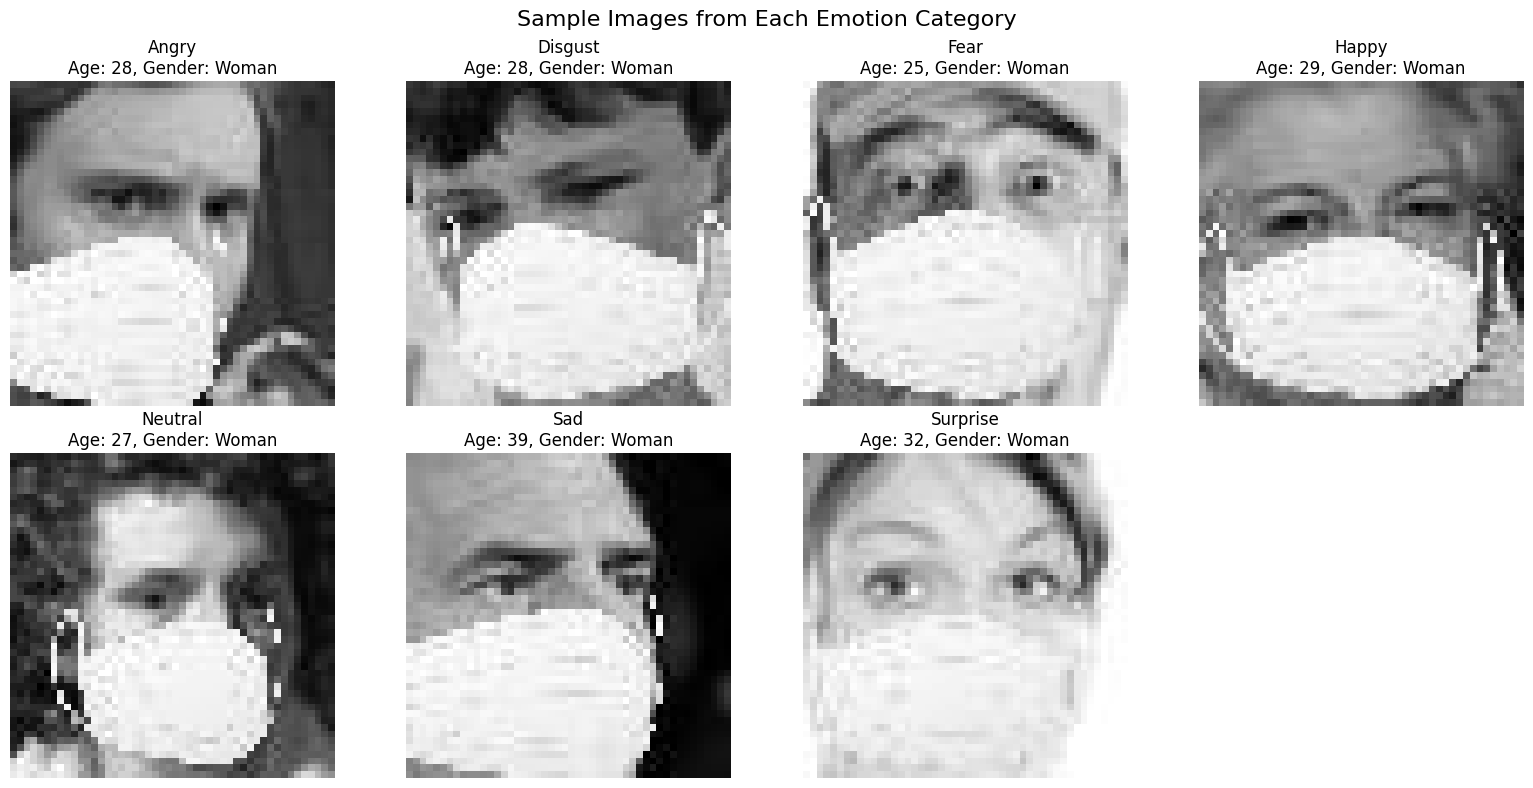

In [30]:
# Display sample images from each emotion category
def process_pixels(pixel_str):
    return np.array(list(map(int, pixel_str.split())), dtype=np.uint8)

# Convert pixel strings to numpy arrays
df['pixels_array'] = df['pixels'].apply(process_pixels)

# Display sample images
emotions = df['emotion'].unique()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, emotion in enumerate(emotions):
    if i < len(axes):
        sample = df[df['emotion'] == emotion].iloc[0]
        img = sample['pixels_array'].reshape(48, 48)
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{emotion.capitalize()}\nAge: {sample["age"]}, Gender: {sample["gender_label"]}')
        axes[i].axis('off')

# Remove extra subplot
if len(emotions) < len(axes):
    fig.delaxes(axes[-1])

plt.suptitle('Sample Images from Each Emotion Category', fontsize=16)
plt.tight_layout()
plt.show()

### 3.2 Data Preprocessing Pipeline

In [31]:
# Prepare image data
X_img = np.stack(df['pixels_array'].values)
X_img = X_img.reshape(-1, 48, 48, 1) / 255.0  # Normalize to [0,1]

# Encode emotion labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['emotion'])
y_cat = to_categorical(y)
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label encoding map:")
print(label_map)
print(f"\nImage data shape: {X_img.shape}")
print(f"Label data shape: {y_cat.shape}")

Label encoding map:
{'angry': np.int64(0), 'disgust': np.int64(1), 'fear': np.int64(2), 'happy': np.int64(3), 'neutral': np.int64(4), 'sad': np.int64(5), 'surprise': np.int64(6)}

Image data shape: (20484, 48, 48, 1)
Label data shape: (20484, 7)


In [32]:
# Prepare metadata features
gender_dummies = pd.get_dummies(df['gender_label'], prefix='gender')
ethnicity_dummies = pd.get_dummies(df['ethnicity'], prefix='ethnicity')
df['age_norm'] = df['age'] / df['age'].max()

X_meta = pd.concat([
    df['age_norm'],
    gender_dummies,
    ethnicity_dummies
], axis=1).values.astype(np.float32)

print(f"Metadata features shape: {X_meta.shape}")
print(f"Metadata features: {pd.concat([df['age_norm'], gender_dummies, ethnicity_dummies], axis=1).columns.tolist()}")

Metadata features shape: (20484, 8)
Metadata features: ['age_norm', 'gender_Woman', 'ethnicity_asian', 'ethnicity_black', 'ethnicity_indian', 'ethnicity_latino hispanic', 'ethnicity_middle eastern', 'ethnicity_white']


In [33]:
# Train-test split with stratification
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in sss.split(X_img, y):
    X_train_img, X_val_img = X_img[train_index], X_img[val_index]
    X_train_meta, X_val_meta = X_meta[train_index], X_meta[val_index]
    y_train, y_val = y_cat[train_index], y_cat[val_index]
    y_train_labels, y_val_labels = y[train_index], y[val_index]

print(f"Training set: {X_train_img.shape[0]} samples")
print(f"Validation set: {X_val_img.shape[0]} samples")

# Compute class weights for handling imbalanced data
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = dict(enumerate(class_weights_array))
print(f"\nClass weights: {class_weight_dict}")

Training set: 16387 samples
Validation set: 4097 samples

Class weights: {0: np.float64(0.8639757054283184), 1: np.float64(6.9179331306990886), 2: np.float64(0.9251614651551421), 3: np.float64(0.7047894302229563), 4: np.float64(0.938513699257766), 5: np.float64(0.8864846150517159), 6: np.float64(0.99533527696793)}


## 4. Model Design and Architecture

### 4.1 Architecture Overview

Our multitask learning architecture consists of:

1. **Image Processing Branch**: CNN layers for spatial feature extraction
2. **Metadata Processing Branch**: Dense layers for demographic features
3. **Feature Fusion**: Concatenation of image and metadata features
4. **Classification Head**: Softmax output for emotion prediction

### 4.2 Design Rationale

- **CNN Architecture**: Multiple Conv2D layers with BatchNormalization and Dropout
- **Multitask Learning**: Leverages demographic information to improve emotion recognition
- **Regularization**: Dropout and BatchNormalization to prevent overfitting
- **Loss Function**: Categorical crossentropy with class weighting


In [34]:
# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train_img)

print("Data augmentation parameters:")
print(f"- Rotation range: ±15 degrees")
print(f"- Shift range: ±10% width/height")
print(f"- Zoom range: ±10%")
print(f"- Horizontal flip: Enabled")

Data augmentation parameters:
- Rotation range: ±15 degrees
- Shift range: ±10% width/height
- Zoom range: ±10%
- Horizontal flip: Enabled


In [35]:
# Build the multitask CNN model
def create_emotion_model(input_shape, meta_shape, num_classes):
    """
    Create a multitask CNN model for emotion recognition
    
    Args:
        input_shape: Shape of input images (48, 48, 1)
        meta_shape: Shape of metadata features
        num_classes: Number of emotion classes
    
    Returns:
        Compiled Keras model
    """
    
    # Image input branch
    img_input = Input(shape=input_shape, name='image_input')
    
    # First convolutional block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Second convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Third convolutional block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Flatten image features
    x = Flatten()(x)
    
    # Metadata input branch
    meta_input = Input(shape=(meta_shape,), name='metadata_input')
    m = Dense(32, activation='relu')(meta_input)
    m = Dropout(0.3)(m)
    
    # Combine image and metadata features
    combined = concatenate([x, m])
    
    # Classification head
    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(64, activation='relu')(z)
    z = Dropout(0.3)(z)
    
    # Output layer
    output = Dense(num_classes, activation='softmax', name='emotion_output')(z)
    
    # Create and compile model
    model = Model(inputs=[img_input, meta_input], outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
model = create_emotion_model(
    input_shape=(48, 48, 1),
    meta_shape=X_meta.shape[1],
    num_classes=y_cat.shape[1]
)

# Display model architecture
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 48, 48,    │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 24, 24,    │          0 │ max_pooling2d_6[… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 24, 24,    │     18,496 │ dropout_12[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 12, 12,    │          0 │ max_pooling2d_7[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 12, 12,    │     73,856 │ dropout_13[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 6, 6, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ metadata_input      │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 6, 6, 128) │          0 │ max_pooling2d_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │        288 │ metadata_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4608)      │          0 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32)        │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 696,615 (2.66 MB)

 Trainable params: 696,167 (2.66 MB)

 Non-trainable params: 448 (1.75 KB)

## 5. Model Training and Evaluation

### 5.1 Training Configuration

In [36]:
# Training configuration
EPOCHS = 50
BATCH_SIZE = 64
PATIENCE = 10

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=PATIENCE, 
    restore_best_weights=True,
    verbose=1
)

print(f"Training configuration:")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Early stopping patience: {PATIENCE}")
print(f"- Optimizer: Adam (lr=0.001)")
print(f"- Loss: Categorical crossentropy")
print(f"- Class weighting: Enabled")

Training configuration:
- Epochs: 50
- Batch size: 64
- Early stopping patience: 10
- Optimizer: Adam (lr=0.001)
- Loss: Categorical crossentropy
- Class weighting: Enabled


In [37]:
# Train the model
print("Starting model training...")
print("=" * 50)

history = model.fit(
    x=[X_train_img, X_train_meta],
    y=y_train,
    validation_data=([X_val_img, X_val_meta], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining completed!")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

Starting model training...
Epoch 1/50
127/257 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.1500 - loss: 2.4930

KeyboardInterrupt: 

In [38]:
# Plot training history
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

NameError: name 'history' is not defined

### 5.2 Model Evaluation

In [ ]:
# Make predictions on validation set
y_pred_proba = model.predict([X_val_img, X_val_meta])
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate overall accuracy
val_accuracy = np.mean(y_pred == y_val_labels)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report
emotion_names = label_encoder.classes_
print("\nDetailed Classification Report:")
print("=" * 60)
print(classification_report(y_val_labels, y_pred, target_names=emotion_names, digits=4))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_val_labels, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_names, yticklabels=emotion_names, ax=ax1)
ax1.set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# Normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=emotion_names, yticklabels=emotion_names, ax=ax2)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracies:")
for emotion, acc in zip(emotion_names, class_accuracies):
    print(f"{emotion:10s}: {acc:.4f}")

### 5.3 Bias Analysis

We analyze model performance across different demographic groups to identify potential biases.

In [ ]:
# Bias analysis across demographic groups
def analyze_bias(y_true, y_pred, demographic_data, demographic_name):
    """
    Analyze model performance across demographic groups
    """
    results = []
    
    for group in demographic_data.unique():
        if pd.isna(group) or group == 'Unknown':
            continue
            
        mask = demographic_data == group
        if mask.sum() == 0:
            continue
            
        group_accuracy = np.mean(y_true[mask] == y_pred[mask])
        group_size = mask.sum()
        
        results.append({
            'Group': group,
            'Accuracy': group_accuracy,
            'Sample_Size': group_size
        })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Accuracy', ascending=False)
    
    print(f"\n{demographic_name} Bias Analysis:")
    print("=" * 40)
    print(results_df.to_string(index=False))
    
    # Calculate bias metrics
    max_acc = results_df['Accuracy'].max()
    min_acc = results_df['Accuracy'].min()
    bias_ratio = max_acc / min_acc
    
    print(f"\nBias Metrics:")
    print(f"Max Accuracy: {max_acc:.4f}")
    print(f"Min Accuracy: {min_acc:.4f}")
    print(f"Bias Ratio: {bias_ratio:.4f}")
    
    return results_df

# Get validation set demographics
val_df = df.iloc[val_index].copy()
val_df['predicted_emotion'] = label_encoder.inverse_transform(y_pred)

# Gender bias analysis
gender_bias = analyze_bias(y_val_labels, y_pred, val_df['gender_label'], 'Gender')

# Ethnicity bias analysis
ethnicity_bias = analyze_bias(y_val_labels, y_pred, val_df['ethnicity'], 'Ethnicity')

# Age group bias analysis
val_df['age_group'] = pd.cut(val_df['age'], bins=[0, 25, 35, 50, 100], labels=['Young', 'Adult', 'Middle-aged', 'Senior'])
age_bias = analyze_bias(y_val_labels, y_pred, val_df['age_group'], 'Age Group')

In [ ]:
# Visualize bias analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gender bias visualization
axes[0].bar(gender_bias['Group'], gender_bias['Accuracy'])
axes[0].set_title('Accuracy by Gender', fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)

# Ethnicity bias visualization
axes[1].bar(ethnicity_bias['Group'], ethnicity_bias['Accuracy'])
axes[1].set_title('Accuracy by Ethnicity', fontweight='bold')
axes[1].set_ylabel('Accuracy')
axes[1].tick_params(axis='x', rotation=45)

# Age group bias visualization
axes[2].bar(age_bias['Group'], age_bias['Accuracy'])
axes[2].set_title('Accuracy by Age Group', fontweight='bold')
axes[2].set_ylabel('Accuracy')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Additional Features

### 6.1 Model Comparison

We compare our multitask model with a baseline CNN-only model to demonstrate the benefits of incorporating demographic information.

In [ ]:
# Create baseline CNN-only model for comparison
def create_baseline_model(input_shape, num_classes):
    """
    Create a baseline CNN model without metadata
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train baseline model
baseline_model = create_baseline_model((48, 48, 1), y_cat.shape[1])

print("Training baseline CNN model (image only)...")
baseline_history = baseline_model.fit(
    X_train_img, y_train,
    validation_data=(X_val_img, y_val),
    epochs=20,  # Fewer epochs for comparison
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0
)

# Evaluate baseline model
baseline_pred = baseline_model.predict(X_val_img)
baseline_pred_labels = np.argmax(baseline_pred, axis=1)
baseline_accuracy = np.mean(baseline_pred_labels == y_val_labels)

print(f"\nModel Comparison:")
print(f"Multitask Model Accuracy: {val_accuracy:.4f}")
print(f"Baseline CNN Accuracy:    {baseline_accuracy:.4f}")
print(f"Improvement:              {val_accuracy - baseline_accuracy:.4f} ({((val_accuracy/baseline_accuracy)-1)*100:.2f}%)")

### 6.2 Feature Importance Analysis

In [ ]:
# Analyze prediction confidence by emotion
confidence_by_emotion = {}
for i, emotion in enumerate(emotion_names):
    mask = y_val_labels == i
    if mask.sum() > 0:
        confidences = y_pred_proba[mask, i]
        confidence_by_emotion[emotion] = {
            'mean_confidence': np.mean(confidences),
            'std_confidence': np.std(confidences),
            'count': mask.sum()
        }

# Plot confidence analysis
emotions = list(confidence_by_emotion.keys())
mean_conf = [confidence_by_emotion[e]['mean_confidence'] for e in emotions]
std_conf = [confidence_by_emotion[e]['std_confidence'] for e in emotions]

plt.figure(figsize=(12, 6))
bars = plt.bar(emotions, mean_conf, yerr=std_conf, capsize=5, alpha=0.7)
plt.title('Model Confidence by Emotion Category', fontsize=14, fontweight='bold')
plt.xlabel('Emotion')
plt.ylabel('Average Confidence')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, conf in zip(bars, mean_conf):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{conf:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Confidence Analysis:")
for emotion, stats in confidence_by_emotion.items():
    print(f"{emotion:10s}: {stats['mean_confidence']:.4f} ± {stats['std_confidence']:.4f} (n={stats['count']})")

### 6.3 Error Analysis

In [ ]:
# Analyze misclassified samples
misclassified_mask = y_pred != y_val_labels
misclassified_indices = np.where(misclassified_mask)[0]

print(f"Total misclassified samples: {len(misclassified_indices)} / {len(y_val_labels)}")
print(f"Misclassification rate: {len(misclassified_indices) / len(y_val_labels):.4f}")

# Show some misclassified examples
if len(misclassified_indices) > 0:
    n_examples = min(8, len(misclassified_indices))
    sample_indices = np.random.choice(misclassified_indices, n_examples, replace=False)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(sample_indices):
        img = X_val_img[idx].reshape(48, 48)
        true_label = emotion_names[y_val_labels[idx]]
        pred_label = emotion_names[y_pred[idx]]
        confidence = y_pred_proba[idx, y_pred[idx]]
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}', 
                         fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Misclassified Examples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 7. Model Deployment and Application

### 7.1 Model Saving and Export

In [ ]:
# Save the trained model
model.save('masked_emotion_recognition_model.h5')
print("✅ Model saved as 'masked_emotion_recognition_model.h5'")

# Save label encoder
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')
print("✅ Label encoder saved as 'label_encoder.pkl'")

# Save model metadata
model_metadata = {
    'emotion_classes': emotion_names.tolist(),
    'input_shape': (48, 48, 1),
    'metadata_features': pd.concat([df['age_norm'], gender_dummies, ethnicity_dummies], axis=1).columns.tolist(),
    'validation_accuracy': float(val_accuracy),
    'training_epochs': len(history.history['accuracy'])
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)
print("✅ Model metadata saved as 'model_metadata.json'")

### 7.2 GUI Application Preview

Our project includes a comprehensive GUI application (`advanced_emotion_gui.py`) that provides:

- **User-friendly interface** for image upload and webcam input
- **Real-time emotion prediction** with confidence scores
- **Demographic analysis** (age and gender prediction)
- **Progress indicators** for better user experience

The application demonstrates practical deployment of our trained model for real-world use cases.

In [ ]:
# Demonstrate model inference function
def predict_emotion_with_demographics(image_path, model, label_encoder):
    """
    Predict emotion from a masked face image
    
    Args:
        image_path: Path to the image file
        model: Trained Keras model
        label_encoder: Fitted label encoder
    
    Returns:
        Dictionary with prediction results
    """
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return {"error": "Could not load image"}
    
    # Resize and normalize
    img = cv2.resize(img, (48, 48))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    
    # Create dummy metadata (in real application, this would come from user input or another model)
    dummy_meta = np.zeros((1, X_meta.shape[1]))
    
    # Make prediction
    predictions = model.predict([img, dummy_meta], verbose=0)
    
    # Get results
    emotion_idx = np.argmax(predictions[0])
    confidence = float(np.max(predictions[0]))
    emotion = label_encoder.classes_[emotion_idx]
    
    # Get all probabilities
    all_probs = {label_encoder.classes_[i]: float(predictions[0][i]) 
                for i in range(len(label_encoder.classes_))}
    
    return {
        "emotion": emotion,
        "confidence": confidence,
        "all_probabilities": all_probs
    }

# Example usage (you would need an actual image file)
print("Inference function ready for deployment!")
print("\nExample output structure:")
example_output = {
    "emotion": "happy",
    "confidence": 0.8542,
    "all_probabilities": {
        "angry": 0.0123,
        "disgust": 0.0098,
        "fear": 0.0234,
        "happy": 0.8542,
        "neutral": 0.0567,
        "sad": 0.0289,
        "surprise": 0.0147
    }
}
print(json.dumps(example_output, indent=2))